#  Loading and processing data

In [1]:
from __future__ import print_function, division
import os
import torch
import torch.nn as nn
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data import sampler

from glob import glob
import pydicom
import pylab

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
#verify our data
data = pd.read_csv('data_full.csv')
data.head()

patientId                         class      x  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal    NaN   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal    NaN   
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal    NaN   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal    NaN   
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity  264.0   

       y  width  height  Target  \
0    NaN    NaN     NaN       0   
1    NaN    NaN     NaN       0   
2    NaN    NaN     NaN       0   
3    NaN    NaN     NaN       0   
4  152.0  213.0   379.0       1   

                                                path  PatientAge ViewPosition  \
0  ../Dataset/all/stage_1_train_images/0004cfab-1...          51           PA   
1  ../Dataset/all/stage_1_train_images/00313ee0-9...          48           PA   
2  ../Dataset/all/stage_1_train_images/00322d4d-1...          19           AP   
3  ../Dataset/all/stage_1_train_images/003d8fa0-6...          28           PA   
4  ../Dataset/all/stage_1_train_images/00436515-8...          32           AP   

  PatientSex  boxes  
0          F    0.0  
1          F    0.0  
2          M    0.0  
3          M    0.0  
4          F    2.0

<class 'numpy.ndarray'>
(1024, 1024)


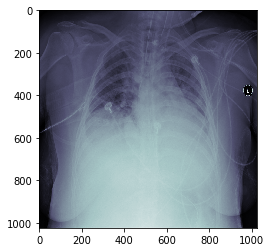

In [9]:
#check data of one image
image=pydicom.read_file(data.path[4])
image=image.pixel_array
print(type(image))
print(image.shape)
plt.imshow(image, cmap='bone')

In [3]:
# for classification problem
data=data[["path","Target"]]

In [4]:
#Loading and processing data

class PneuDataset(Dataset):
    """RSNA Pneumonia dataset."""

    def __init__(self, path_data, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.path_data= path_data
        self.transform = transform

    def __len__(self):
        return len(self.path_data)

    def __getitem__(self, idx):
        image=pydicom.read_file(self.path_data.path[idx]).pixel_array
        label=self.path_data.Target[idx]
        if self.transform:
            image = self.transform(image)
        sample = {'image': image, 'label': label}

        return sample

In [5]:
PneuData=PneuDataset(path_data=data)

In [6]:
class Rescale(object):
    """Rescale the image in a sample to a size 224*224.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        sample['image'] = transform.resize(image, self.output_size)

       
        return sample


class Flip(object):
    """Rotate the image in a sample.

    """

    def __call__(self, sample):
        image= sample['image']

        sample['image'] = np.fliplr(image)


        return sample


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']
        sample['image']=torch.from_numpy(image)

       
        return sample

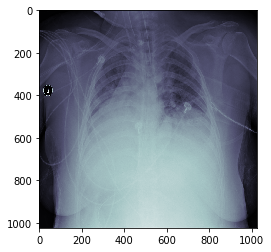

In [14]:
plt.imshow(np.fliplr(image), cmap='bone')

In [76]:
scale=Rescale((224,224))
flip=Flip()
transform=transforms.Compose([scale,flip, ToTensor()])                                        
# transformed_data = transform(pneu_data)
# plt.imshow(transform(pneu_data)[0]['image'], cmap='bone')

In [16]:
pneu_data=PneuDataset(path_data=data, transform=None)

In [17]:
print(len(pneu_data))
sample=pneu_data[0]
print(sample['image'].shape)

28989
(1024, 1024)


In [78]:
for sample in pneu_data:
    print(sample)

In [74]:
pneu_data=PneuDataset(path_data=data)

In [37]:
len(pneu_data)

28989

In [38]:
#prepare data
train_size = int(0.8 * len(pneu_data))
test_size = len(pneu_data) - train_size
training_size=int(0.8*train_size)
val_size=train_size-training_size
training_dataset, val_dataset, test_dataset = torch.utils.data.random_split(pneu_data, [training_size, val_size, test_size])



training_loader = DataLoader(training_dataset, batch_size=4, shuffle=True, num_workers=0)

val_loader=DataLoader(val_dataset, batch_size=4,shuffle=False, num_workers=0)

test_loader=DataLoader(training_dataset, batch_size=4,
                        shuffle=False, num_workers=0)


In [39]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)



VGG19=nn.Sequential(
    nn.Conv2d(3,64, 3,padding=1),
    nn.Conv2d(64,64, 3,padding=1),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(64,128, 3, padding=1),
    nn.Conv2d(128,128, 3, padding=1),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(128,256, 3, padding=1),
    nn.Conv2d(256,256, 3, padding=1),
    nn.Conv2d(256,256, 3, padding=1),
    nn.Conv2d(256,256, 3, padding=1),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(256,512, 3, padding=1),
    nn.Conv2d(512,512, 3, padding=1),
    nn.Conv2d(512,512, 3, padding=1),
    nn.Conv2d(512,512, 3, padding=1),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(512,512, 3, padding=1),
    nn.Conv2d(512,512, 3, padding=1),
    nn.Conv2d(512,512, 3, padding=1),
    nn.Conv2d(512,512, 3, padding=1),
    nn.MaxPool2d(2, stride=2),
    Flatten(),
    nn.Linear(7*7*512,4906),
    nn.Linear(4906,4906),
    nn.Linear(4906,2),
)


def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

def train_model(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy(loader_val, model)
                print()


In [54]:
#train one-size sample
num_train=1
sample_train = DataLoader(pneu_data, batch_size=1,sampler=sampler.SubsetRandomSampler(range(num_train)))


In [41]:
print(len(sample_train))

1


In [56]:
for batch_smaple in sample_train:
    print(batch_smaple)

(1024, 1024)
0


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [55]:
loader_train=sample_train
for t, batch_sample in enumerate(loader_train):
    print(t)


(1024, 1024)
0


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
learning_rate = 1e-2
model = VGG19()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_model(model, optimizer,epochs=1)